# Lecture 10. Neural Networks for text

**Turning text into numbers**

Joaquin Vanschoren

In [1]:
# Global imports and settings
from preamble import *
import tensorflow as tf
import tensorflow.keras as keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

%matplotlib inline
interactive = True # Set to True for interactive plots 
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.4
    plt.rcParams.update(print_config)

## Overview
* Word embeddings
    * Word2Vec, FastText, GloVe
    * Neural networks on word embeddings
* Sequence-to-sequence models
    * Self-attention
    * Transformer models

## Bag of word representation
* First, build a _vocabulary_ of all occuring words. Maps every word to an index.
* Represent each document as an $N$ dimensional vector (top-$N$ most frequent words)
    * One-hot (sparse) encoding: 1 if the word occurs in the document
* Destroys the order of the words in the text (hence, a 'bag' of words)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/bag_of_words.png" alt="ml" style="width: 60%"/>

Example: IMBD review database
* 50,000 reviews, labeled positive (1) or negative (0)
    * Every row (document) is one review, no other input features
    * Already tokenized. All markup, punctuation,... removed

In [2]:
from keras.datasets import imdb
word_index = imdb.get_word_index()
print("Text contains {} unique words".format(len(word_index)))

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(index_from=0)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

for r in [0,5,10]:
    print("\nReview {}:".format(r),' '.join([reverse_word_index.get(i, '?') for i in train_data[r]][0:50]))

Text contains 88584 unique words

Review 0: the this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved

Review 5: the begins better than it ends funny that the russian submarine crew outperforms all other actors it's like those scenes where documentary shots br br spoiler part the message dechifered was contrary to the whole story it just does not mesh br br

Review 10: the french horror cinema has seen something of a revival over the last couple of years with great films such as inside and switchblade romance bursting on to the scene maléfique preceded the revival just slightly but stands head and shoulders over most modern horror titles and is surely one


### Bag of words with one-hot-encoding
* Encoded review: shows the list of word IDs. Words are sorted by frequency of occurance.
    * Allows to easily remove the most common and least common words
* One-hot-encoded review: '1' if the word occurs. 
    * Only the first 100 of 10000 values are shown

In [3]:
# Custom implementation of one-hot-encoding. 
# dimension is the dimensionality of the output (default 10000).
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # create empty vector of length N
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data, dimension=len(word_index))
x_test = vectorize_sequences(test_data, dimension=len(word_index))

In [4]:
print("Review {}:".format(3),' '.join([reverse_word_index.get(i, '?') for i in train_data[3]][0:80]))
print("\nEncoded review: ", train_data[3][0:80])
print("\nOne-hot-encoded review: ", x_train[3][0:80])

Review 3: the the scots excel at storytelling the traditional sort many years after the event i can still see in my mind's eye an elderly lady my friend's mother retelling the battle of culloden she makes the characters come alive her passion is that of an eye witness one to the events on the sodden heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from

Encoded review:  [1, 1, 18606, 16082, 30, 2801, 1, 2037, 429, 108, 150, 100, 1, 1491, 10, 67, 128, 64, 8, 58, 15302, 741, 32, 3712, 758, 58, 5763, 449, 9211, 1, 982, 4, 64314, 56, 163, 1, 102, 213, 1236, 38, 1794, 6, 12, 4, 32, 741, 2410, 28, 5, 1, 684, 20, 1, 33926, 7336, 3, 3690, 39, 35, 36, 118, 56, 453, 7, 7, 4, 262, 9, 572, 108, 150, 156, 56, 13, 1444, 18, 22, 583, 479, 36]

One-hot-encoded review:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0

### Word counts
* Count the number of times each word appears in the document
* Example using sklearn `CountVectorizer` (on 2 documents)
* In practice, we also:
    * Preprocess the text (tokenization, stemming, remove stopwords, ...)
    * Use _n-grams_ ("not terrible", "terrible acting",...), _character n-grams_ ('ter', 'err', 'eri',...)
    * Scale the word-counts (e.g. L2 normalization or TF-IDF)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit count vectorizer on a few documents (here: 2)
line = [' '.join([reverse_word_index.get(i, '?') for i in train_data[d]][0:50]) for d in range(2)]
vect = CountVectorizer()
vect.fit(line)
print("Vocabulary (feature names) after fit:", vect.get_feature_names_out())

# Transform the data
# Returns a sparse matrix
X = vect.transform(line)
print("Count encoding doc 1:", X.toarray()[0])
print("Count encoding doc 2:", X.toarray()[1])

Vocabulary (feature names) after fit: ['actor' 'amazing' 'an' 'and' 'are' 'as' 'bad' 'be' 'being' 'best' 'big'
 'boobs' 'brilliant' 'but' 'came' 'casting' 'cheesy' 'could' 'describe'
 'direction' 'director' 'ever' 'everyone' 'father' 'film' 'from' 'giant'
 'got' 'had' 'hair' 'horror' 'hundreds' 'imagine' 'is' 'island' 'just'
 'location' 'love' 'loved' 'made' 'movie' 'movies' 'music' 'myself'
 'norman' 'now' 'of' 'on' 'paper' 'part' 'pin' 'played' 'plot' 'really'
 'redford' 'ridiculous' 'robert' 'safety' 'same' 'scenery' 'scottish'
 'seen' 'so' 'story' 'suited' 'terrible' 'the' 'there' 'these' 'they'
 'thin' 'this' 'to' 've' 'was' 'words' 'worst' 'you']
Count encoding doc 1: [1 1 1 2 0 1 0 0 2 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 2 1
 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 2 1 1 0 1 1 1 0 4 1 0 1 0 1 0 0
 1 0 0 1]
Count encoding doc 2: [0 0 0 3 1 0 1 1 0 1 2 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0
 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 4

### Classification
* With this tabular representation, we can fit any model (e.g. Logistic regression)
* Visualize coefficients: which words are indicative for positive/negative reviews?

In [6]:
from sklearn.linear_model import LogisticRegressionCV

# Fit CountVectorizer on the first 5000 reviews 
data_size = 5000 # You can get a few % better in the full dataset, but takes longer
train_text = [' '.join([reverse_word_index.get(i, '?') for i in train_data[d]]) for d in range(data_size)]
test_text = [' '.join([reverse_word_index.get(i, '?') for i in test_data[d]]) for d in range(data_size)]

vect = CountVectorizer()
train_text_vec = vect.fit_transform(train_text)
test_text_vec = vect.transform(test_text)

lr = LogisticRegressionCV().fit(train_text_vec, train_labels[:data_size])
acc = lr.score(test_text_vec, test_labels[:data_size])
print("Logistic regression accuracy:",acc)

Logistic regression accuracy: 0.8538


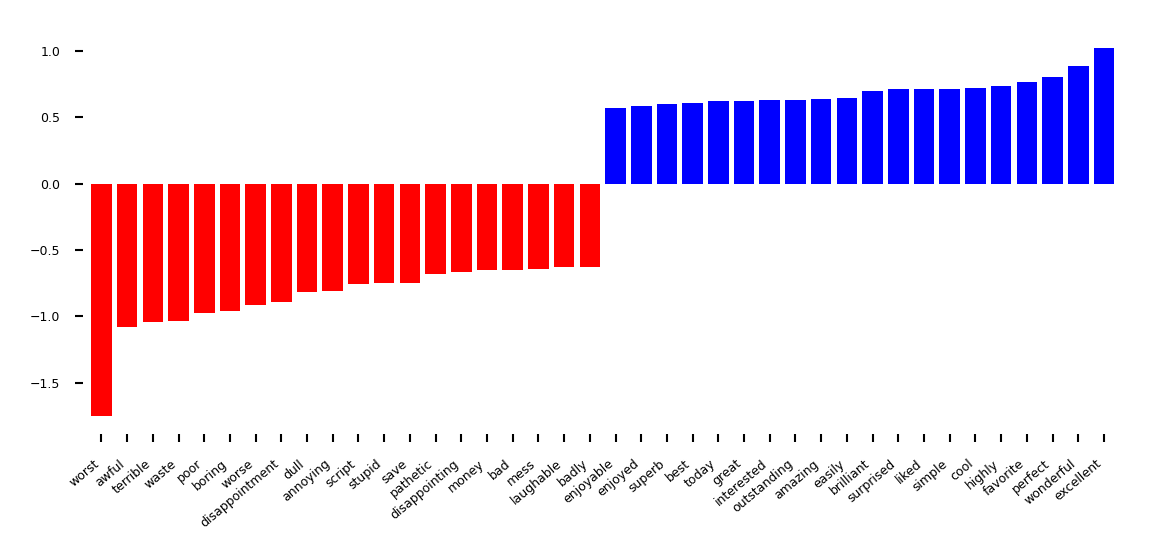

In [7]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)
plt.figure(figsize=(9*fig_scale, 3.5*fig_scale))
plot_important_features(lr.coef_.ravel(), np.array(vect.get_feature_names_out()), top_n=20, rotation=40)
ax = plt.gca()

### Preprocessing
* Tokenization: how to you split text into words? On spaces only? Also -, ` ? 
* Stemming: naive reduction to word stems. E.g. 'the meeting' to 'the meet'
    * Lemmatization: smarter reduction (NLP-based). E.g. distinguishes between nouns and verbs
* Discard stop words ('the', 'an',...)
* Only use $N$ (e.g. 10000) most frequent words
 * Or, use a hash function (risks collisions)
* n-grams: Use combinations of $n$ adjacent words next to individual words
    * e.g. 2-grams: "awesome movie", "movie with", "with creative", ...
* Character n-grams: combinations of $n$ adjacent letters: 'awe', 'wes', 'eso',...
* Useful libraries: [nltk](https://www.nltk.org/), [spaCy](https://spacy.io/), [gensim](https://radimrehurek.com/gensim/),...

### Scaling
* L2 Normalization (vector norm): sum of squares of all word values equals 1
    * Normalized Euclidean distance is equivalent to cosine distance
    * Works better for distance-based models (e.g. kNN, SVM,...)
$$ t_i = \frac{t_i}{\| t\|_2 }$$

* Term Frequency - Inverted Document Frequency (TF-IDF)
    * Scales value of words by how frequently they occur across all $N$ documents
    * Words that only occur in few documents get higher weight, and vice versa

$$ t_i = t_i \cdot log(\frac{N}{|\{d \in D : t_i \in d\}|})$$

* Usually done in preprocessing, e.g. sklearn `Normalizer` or `TfidfTransformer`
    * L2 normalization can also be done in a `Lambda` layer
```python
model.add(Lambda(lambda x: tf.linalg.normalize(x,axis=1)))
```

## Neural networks on bag of words
* We can also build neural networks on bag-of-word vectors
    - E.g. Use one-hot-encoding with 10000 most frequent words
* Simple model with 2 dense layers, ReLU activation, dropout
    - Binary classification: single output node, sigmoid activation, binary cross-entropy loss
    
``` python
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
```

In [8]:
# Load data with 10000 words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# One-hot-encoding
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [9]:
# Callback for plotting
# TODO: move this to a helper file

from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8*fig_scale,3*fig_scale))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
            
plot_losses = TrainingPlot()

### Evaluation
* Take a validation set of 10,000 samples from the training set
* The validation loss peaks after a few epochs, after which the model starts to overfit
    * Performance is better than Logistic regression

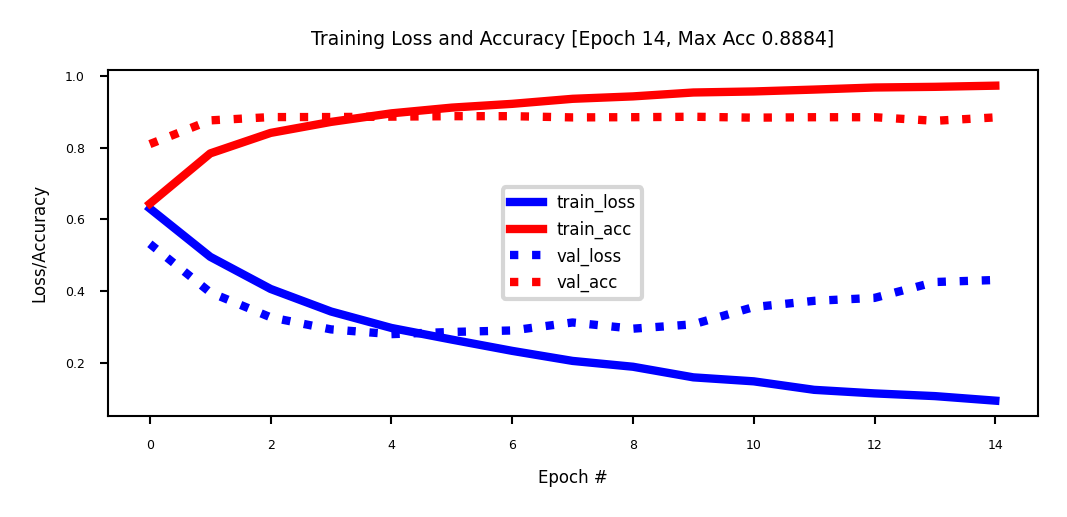

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers

x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                    epochs=15, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Predictions
Let's look at a few predictions:

In [11]:
predictions = model.predict(x_test)
print("Review 0: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]]))
print("Predicted positiveness: ", predictions[0])
print("\nReview 16: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[16]]))
print("Predicted positiveness: ", predictions[16])

782/782 [==============================] - 2s 2ms/step
Review 0:  ? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss
Predicted positiveness:  [0.021]

Review 16:  ? from 1996 first i watched this movie i feel never reach the end of my satisfaction i feel that i want to watch more and more until now my god i don't believe it was ten years ago and i can believe that i almost remember every word of the dialogues i love this movie and i love this novel absolutely perfection i love willem ? he has a strange voice to spell the words black night and i always say it for many times never being bored i love the music of it's so much made me come into another world deep in my heart anyone can feel what i feel and anyone c

## Word Embeddings
* An embedding maps each word to a point in a much smaller $m$-dimensional space
    * E.g. from 10.000 (one-hot-encoded) to 300 (embedded) dimensions
* 2 main approaches:
    * Learn the embedding from scratch
        * Add an _embedding layer_ with $m$ hidden nodes to map word IDs to an $m$-dimensional vector
        * Add your hidden and output layers, learn weights end-to-end with SGD
    * Use a pre-trained embedding
        * Pre-trained on another, much bigger task (e.g. Wikipedia, Google News,...)
        * Freeze embedding weights to produce simple word embeddings, or finetune to a new tasks

### Training Embedding layers from scratch
* Input layer uses fixed length documents (with 0-padding). 2D tensor (samples, max_length)
* Add an _embedding layer_ to learn the embedding
    * Create $n$-dimensional one-hot encoding. 3D tensor (samples, max_length, $n$)
    * To learn an $m$-dimensional embedding, use $m$ hidden nodes. Weight matrix $W^{n x m}$
    * Linear activation function: $\mathbf{X}_{embed} = W \mathbf{X}_{orig}$. 3D tensor (samples, max_length, $m$)
* Add layers to map word embeddings to the desired output. Learn all weights from data.


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_embeddinglayer.png" alt="ml" style="width: 50%">

### Pre-trained embeddings
* With more data we can build better embeddings, but we also need more labels
* Solution: learn embedding on auxiliary task that doesn't require labels 
    * E.g. given a word, predict the surrounding words.
    * Also called self-supervised learning. Supervision is provided by data itself
* Most common approaches:
    * Word2Vec: Learn neural embedding for a word based on surrounding words
    * GloVe (Global Vector): Count co-occurrences of words in a matrix
        * Use a low-rank approximation to get a latent vector representation
    * FastText: learns embedding for character n-grams
        * Can also produce embeddings for new, unseen words

#### Word2Vec
- Move a window over text to get $C$ context words ($V$-dim one-hot encoded)
- Add hidden layer with $N$ linear nodes, average pooling, and softmax layer(s)
- CBOW: predict word given context, use weights of last layer as embedding
- Skip-Gram: predict context given word, use weights of first layer as embedding (better for large corpora)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_word_embeddings_3.png" alt="ml" style="width: 600px;"/>

#### Word2Vec properties
* Word2Vec happens to learn [interesting relationships](https://www.aclweb.org/anthology/N13-1090/) between words
    * Simple vector arithmetic can map words to plurals, conjugations, gender analogies,...
    * e.g. Gender relationships: $vec_{king} - vec_{man} + vec_{woman} \sim vec_{queen}$ 
    * PCA applied to embeddings shows Country - Capital relationship
* Careful: embeddings can capture [gender and other biases](https://arxiv.org/abs/1607.06520) present in the data.
    * Important unsolved problem!

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/word2vec.png" alt="ml" style="width: 800px;"/>

#### FastText
* Limitations of Word2Vec:
    * Cannot represent new (out-of-vocabulary) words
    * Words like 'meet' and 'meeting' are learned independently: less efficient (no parameter sharing)
* FastText addresses this by using character n-grams
    * Basic model can be Skip-gram or CBOW
    * Words are represented by all character n-grams of length 3 to 6
        * "football" 3-grams: <fo, foo, oot, otb, tba, bal, all, ll>
        * Because there are so many n-grams, they are hashed
            * Dimensionality V = bin size
        * Representation of word "football" is sum of its n-gram embeddings
* Training with positive examples (in-context words) and random negative examples  

#### Global Vector model (GloVe)
* Builds a co-occurence matrix $\mathbf{X}$
    * Counts how often 2 words occur in the same context (and how close)
* Learns a k-dimensional embedding $w$ through matrix factorization with rank k
    * Actually learns 2 embeddings $w$ and $w'$ (differ in random initialization)
* Minimizes loss $\mathcal{L}$, where $b_i$ and $b'_i$ are bias terms and $f$ is a weighting function

$$\mathcal{L} = \sum_{i,j=1}^{V} f(\mathbf{X}_{ij}) (\mathbf{w_i} \mathbf{w'_j} + b_i + b'_j - log(\mathbf{X}_{ij}))^2$$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/glove3.png" alt="ml" style="width: 800px;"/>

### Document/paragraph embeddings
* Simplest approach to represent a document: sum or average of all word vectors
* Doc2Vec 
    * Next to word embeddings, also learn an embedding for the document/paragraph
    * Acts as a memory that remembers what is missing from the current context (the topic of the paragraph)
    * Can be used to determine semantic similarity between documents. 
    * Can be tricky to train.
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/doc2vec.png" alt="ml" style="width:600px;"/>

## Neural networks on word embeddings
* Say that we have m-dimensional word embeddings and documents of size $l$
* Our embedding layer will produce a 3D tensor of shape (samples, $l$, $m$)
* We now need to map this to the desired output
    * Simply flattening the tensor learns a direct mapping. This destroys the word order.
    * A recurrent neural network (RNN) could leverage the exact sequence of the words
        * Can be slow to train, have limited memory of previous terms
    * A 1D convolutional network can also leverage locality (learn local patterns)
        * Often competitive with RNNs, and much faster/cheaper
        * Works well for simple tasks like classification and forecasting
    * Attention-based networks can learn which previous terms to pay more attention to
        * Mostly for sequence-to-sequence tasks (e.g. language translation)
        * Transformers: use attention only, no RNNs ([paper](https://arxiv.org/abs/1706.03762), [video](https://www.youtube.com/watch?v=iDulhoQ2pro))

### Training embedding layers from scratch
* Simple model with an embedding layer and direct mapping to binary class
    * Embedding layer is trained from scratch

```python
max_length = 20 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 16 # embedding length (more would be better)

model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
```

In [27]:
max_length = 20 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 16 # embedding length

# define the model
model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 16)            160000    
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 321       
                                                                 
Total params: 160,321
Trainable params: 160,321
Non-trainable params: 0
_________________________________________________________________


* Training on the IMDB dataset (not better than bag-of-words)

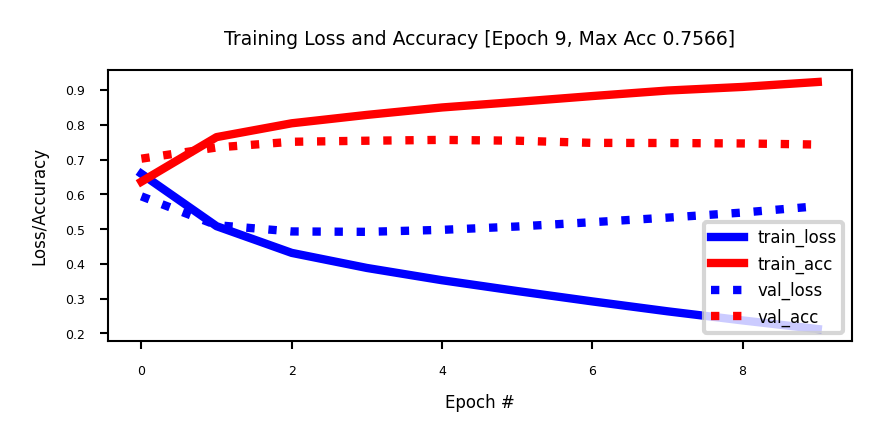

In [28]:
from keras import preprocessing

# Load reviews again
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Turn word ID's into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_length)

model.fit(x_train, y_train, epochs=10, verbose=0,
          batch_size=32, validation_split=0.2, callbacks=[plot_losses]);

### 1D convolutional networks
* Similar to 2D convnets, 1D convnets extract local 1D patches from image tensors
    * Apply identical transformation (filter) to every patch 
* Pattern learned can later be recognized elsewhere (translation invariance)
* 1D Pooling: extracts 1D patches and outputs the max value (max pooling) or average

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/1Dconvnet.png" alt="ml" style="width:500px;"/>

#### Conv1D model
* First layer learns the word embeddings
* Two 1D convolutional layers with MaxPooling
* The latter does global max pooling (over the entire time dimension)
* One dense layer with dropout

```python
model = Sequential()
model.add(layers.Embedding(10000, 128, input_length=100))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
```

* A lot better than the previous self-trained embeddings.
* Starts overfitting after a few epochs, needs regularization (try at home)
* Let's try _pretrained_ embeddings together with 1D convolutional layers

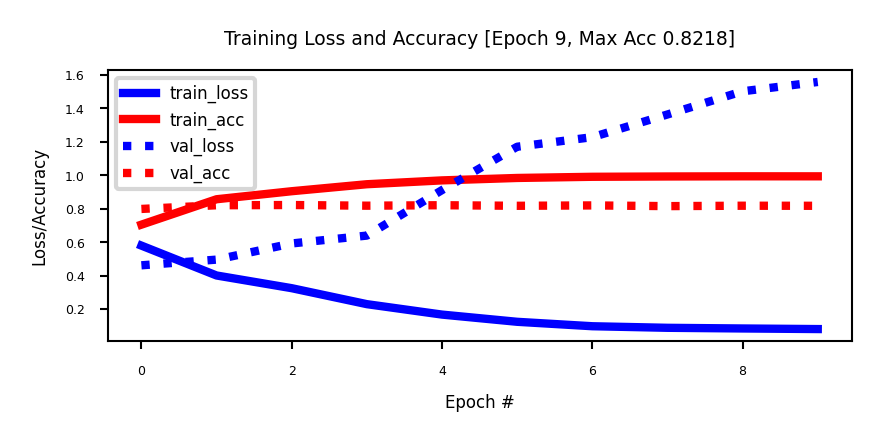

157/157 [==============================] - 3s 18ms/step - loss: 0.0807 - accuracy: 0.9932 - val_loss: 1.5570 - val_accuracy: 0.8172


In [29]:
max_words = 10000
max_length = 100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_length)

model = models.Sequential()
model.add(layers.Embedding(max_words, 128, input_length=max_length))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[plot_losses])

### Using pretrained embeddings

* Download the [GloVe embeddings trained on Wikipedia](https://nlp.stanford.edu/projects/glove) (400k words)
* Use it to build an _embedding matrix_ of shape (max_words, embedding_dim)
* Use this to initialize the embedding layer and freeze it

```python
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False, # Freeze the pretrained weights
)
```

In [40]:
# To find the original data files, see
# http://nlp.stanford.edu/data/glove.6B.zip
# http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz

import tarfile
import gdown

data_dir = '../data'
if not os.path.exists(os.path.join(data_dir,"glove.txt")):
    # Download GloVe embedding
    url = 'https://drive.google.com/uc?id=1ZOd5P9kreaBYg5Oh2n5McC-BozYcsKIH'
    output = os.path.join(data_dir,"glove.txt")
    gdown.download(url, output, quiet=False)
    
    # Unpack 20-newsgroup data 
    my_tar = tarfile.open(os.path.join(data_dir,'news20.tar.gz'))
    my_tar.extractall(data_dir) # specify which folder to extract to
    my_tar.close()

In [42]:
# Build an index so that we can later easily compose the embedding matrix
embeddings_index = {}
with open(os.path.join(data_dir, 'glove.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Practical example

* Dataset: [20 newsgroups dataset](http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20)
    * 20,000 message board messages belonging to 20 different topic categories
* Preprocess the data: vectorize using Keras' `TextVectorization` layer
    * Lowercasing, punctuation removal, tokenization, indexing, integer encoding (or TFIDF)

```python
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
x_train = vectorizer(np.array([[s] for s in train_samples]))
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
```

In [44]:
import os

# Get raw training data
news_dir = os.path.join(data_dir,'20_newsgroup')
dirnames = os.listdir(news_dir)
fnames = os.listdir(news_dir + "/comp.graphics")
#print(open(os.path.join(news_dir, "comp.graphics", "38987")).read())

samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(news_dir)):
    class_names.append(dirname)
    dirpath = news_dir + "/" + dirname
    fnames = os.listdir(dirpath)
    #print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath + "/" + fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

#print("Classes:", class_names)
print("Number of samples:", len(samples))

Number of samples: 19997


In [45]:
from tensorflow.keras.layers import TextVectorization

# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

# Vectorize the data. Takes a while!
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

# Vocabulary
voc = vectorizer.get_vocabulary()

* With the vocabulary of the input dataset, we can build the embedding matrix
* The vocabulary has 2000 tokens, and we used 100D GloVe embeddings

```python
for word, i in word_index.items():
    embedding_matrix[i] = embeddings_index.get(word)
    
embedding_layer = layers.Embedding(
    num_tokens, # 20000
    embedding_dim, # 100
    embeddings_initializer=keras.initializers.Constant(embedding_matrix)
    trainable=False, # Freeze the pretrained weights
)
```

In [46]:
num_tokens = len(voc) + 2
word_index = dict(zip(voc, range(len(voc))))

embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 17999 words (2001 misses)


In [48]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### Conv1D model
* First layer learns the word embeddings)
* Three 1D convolutional layers with MaxPooling
* One dense layer with dropout
* Output later (20 classes) with softmax activation

```python
model = models.Sequential()
model.add(embedding_layer) # Pretrained with on GloVe
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation="softmax"))
```

In [67]:
keras.backend.clear_session() 

model = models.Sequential()
model.add(layers.Input(shape=(None,), dtype="int64"))
model.add(embedding_layer)
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               1

In [68]:
# Build vectorized train and test sets
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

Decent performing model, yet still overfitting: more regularization (or more data) is needed.
* Do explore ways to make the model overfit less.

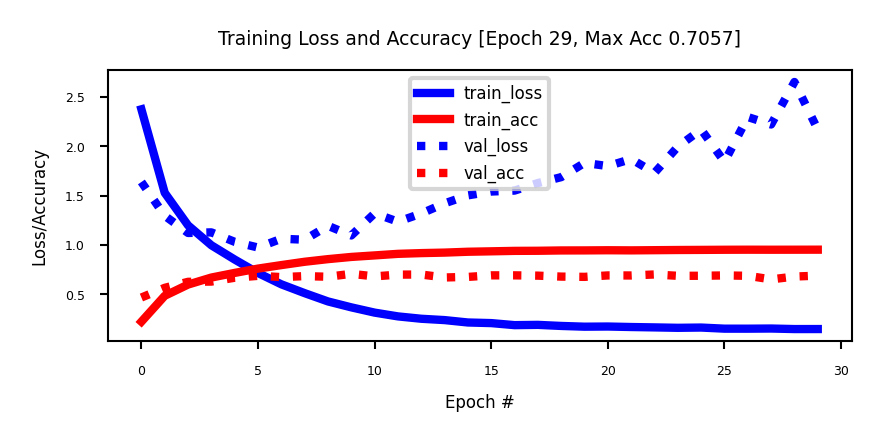

250/250 [==============================] - 3s 11ms/step - loss: 0.1460 - accuracy: 0.9509 - val_loss: 2.1686 - val_accuracy: 0.6874


In [69]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val), callbacks=[plot_losses])

## Summary
* Bag of words representations
    * Useful, but limited, since they destroy the order of the words in text
* Word embeddings
    * Learning word embeddings from labeled data is hard, you may need a lot of data
    * Pretrained word embeddings
        * Word2Vec: learns good embeddings and interesting relationships
        * FastText: can also compute embeddings for entirely new words
        * GloVe: also takes the global context of words into account
        * Language models: state-of-the-art, but expensive
* 1D convolutional nets 
    * Allow us to use the sequence of the words in text, cheaper than RNNs
* In practice
    * Using pretrained embeddings gives good performance
        * Embedding weights can be frozen or finetuned to the task at hand
    * Nowadays these problems are better solved by language models, but that's for another lecture/ course